<a href="https://colab.research.google.com/github/aoisohei/cheat_sheet_computer_vision/blob/main/search_and_cutting_faces1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tqdm

     |████████████████████████████████| 71kB 4.0MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import os 
os.kill(os.getpid(), 9)

In [ ]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 487, done.
remote: Total 487 (delta 0), reused 0 (delta 0), pack-reused 487
Receiving objects: 100% (487/487), 12.71 MiB | 24.14 MiB/s, done.
Resolving deltas: 100% (265/265), done.


In [ ]:
cd stylegan-encoder

/content/stylegan-encoder


In [ ]:
ls

adaptive.py                            Play_with_latent_directions.ipynb
align_images.py                        pretrained_example.py*
config.py*                             README.md*
dataset_tool.py*                       requirements.txt
dnnlib/                                robust_loss/
encode_images.py                       run_metrics.py*
encoder/                               StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset/                          swa.py
generate_figures.py*                   teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt*                           training/
metrics/                               train.py*
mona_example.jpg                       train_resnet.py


### Some housekeeping: setting up folder structure for our images:

In [ ]:
rm -rf aligned_images raw_images

In [ ]:
mkdir aligned_images raw_images

## Les conseils :

Some tips for the images:
```
Use HD images (preferably > 1000x1000 pixels)
Make sure your face is not too small
Neutral expressions & front facing faces will give better results
Clear, uniform lighting conditions are also recommened
```
Upload Images manually (usually gives the best results)

```
Click the '>' icon in the panel on the top left
Go to the 'Files' tab
Unfold the stylegan-encoder folder (left-click)
Right click the 'stylegan-encoder/raw_images' folder and click "upload"
I'd recommend starting with 3 - 6 different images containing faces
```

Take images using your webcam





In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
from datetime import datetime

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(quality=1.0, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))
  
  timestampStr = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
  filename = 'raw_images/photo_%s.jpeg' %timestampStr
  Image.fromarray(img).save(filename)
  print('Image captured and saved to %s' %filename)

In [ ]:
img = take_photo() # click the image to capture a frame!

Found 21 images in raw_images
['1.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '15.jpeg', '16.jpeg', '17.jpeg', '18.jpeg', '19.jpeg', '2.jpeg', '21.jpeg', '22.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']


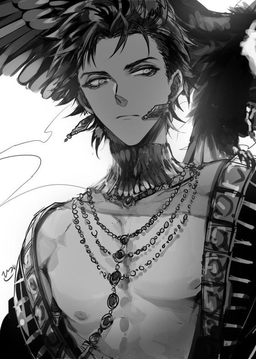

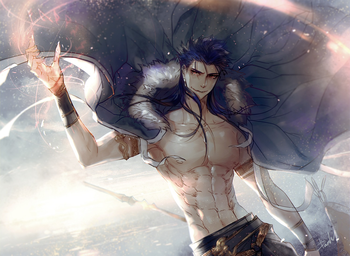

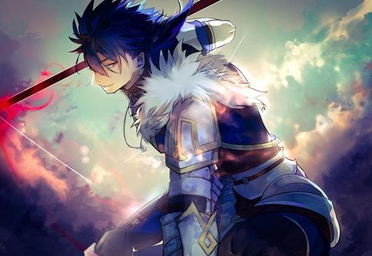

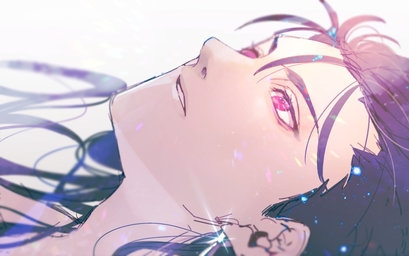

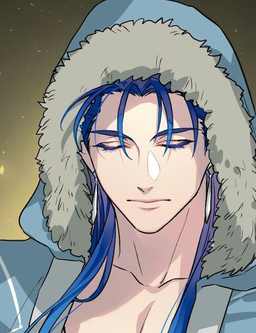

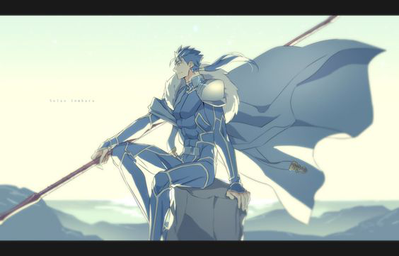

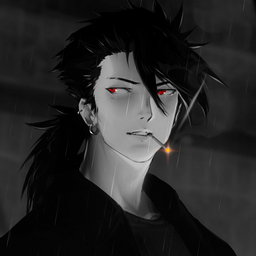

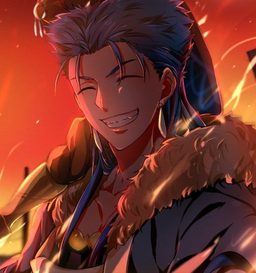

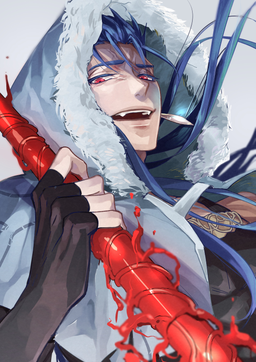

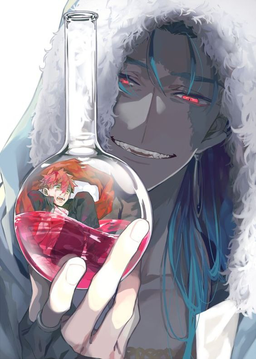

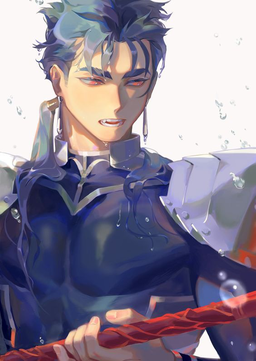

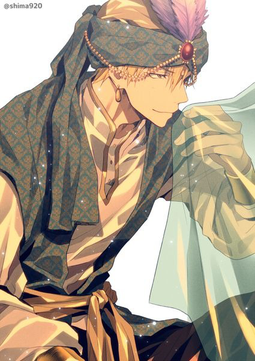

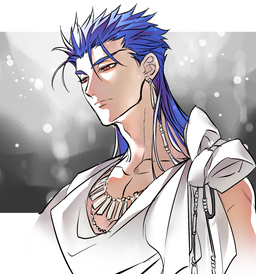

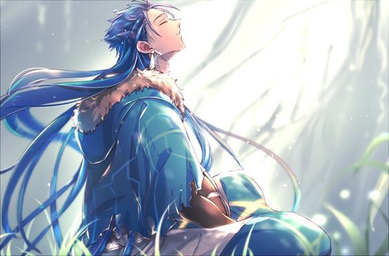

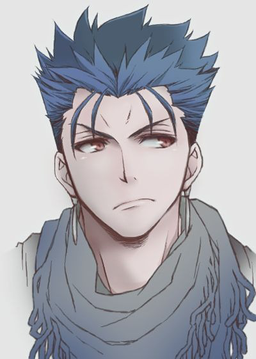

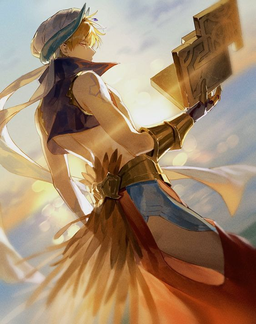

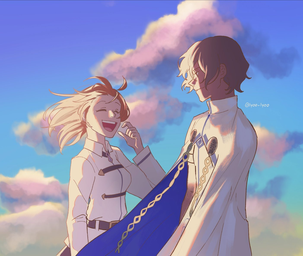

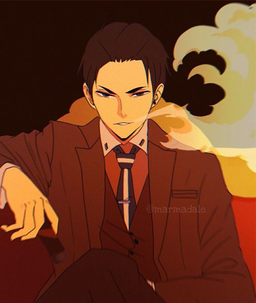

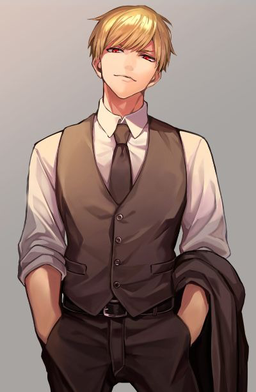

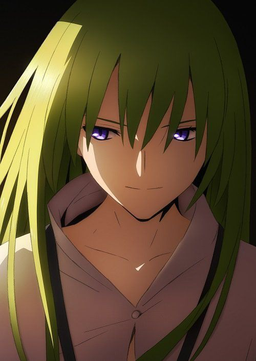

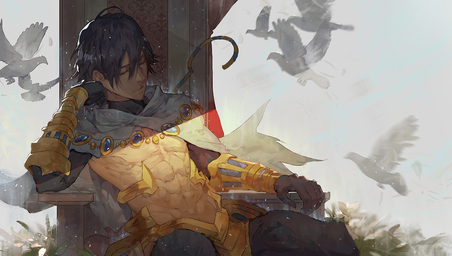

In [ ]:
# Let's check the contents of our image folder before we start:

from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

In [ ]:
# Make sure we're using the right TensorFlow version (1.15):

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
# This script wil:
# --- Look for faces in the images
# --- Crop out the faces from the images
# --- Align the faces (center the nose and make the eyes horizontal)
# --- Rescale the resulting images and save them in "aligned_images" folder

!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 3s 0us/step
Aligning 5.jpeg ...
Getting landmarks...
Aligning 22.jpeg ...
Getting landmarks...
Aligning .ipynb_checkpoints ...
Getting landmarks...
Exception in landmark detection!
Aligning 7.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/7_01.png
Aligning 8.jpeg ...
Getting landmarks...
Aligning 6.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/6_01.png
Aligning 14.jpeg ...
Getting landmarks...
Aligning 19.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/19_01.png
Aligning 13.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/13_01.png
Aligning 3.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/3_01.png


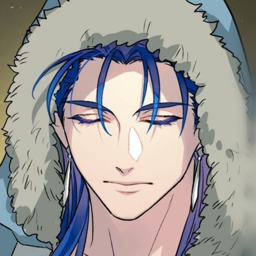

'img 0: 13_01.png'

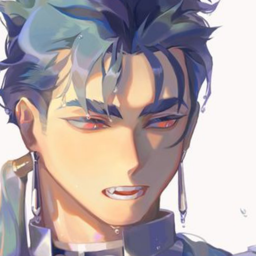

'img 1: 19_01.png'

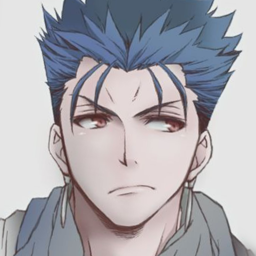

'img 2: 3_01.png'

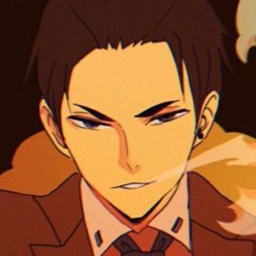

'img 3: 6_01.png'

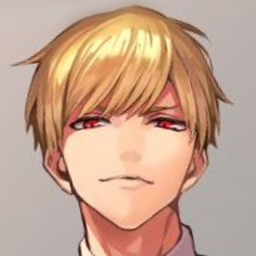

'img 4: 7_01.png'

In [ ]:
# Let's take a look at our aligned images:

def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')